In [109]:
%matplotlib inline
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
# from pmdarima.arima import auto_arima
import xgboost as xgb
import prophet

In [26]:
df = pd.read_csv("owid-covid-data.csv")
df

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2/24/2020,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2/25/2020,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2/26/2020,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2/27/2020,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2/28/2020,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166321,ZWE,Africa,Zimbabwe,3/1/2022,236871.0,491.0,413.000,5395.0,0.0,1.000,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
166322,ZWE,Africa,Zimbabwe,3/2/2022,237503.0,632.0,416.286,5396.0,1.0,1.143,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
166323,ZWE,Africa,Zimbabwe,3/3/2022,237503.0,0.0,362.286,5396.0,0.0,0.857,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
166324,ZWE,Africa,Zimbabwe,3/4/2022,238739.0,1236.0,467.429,5397.0,1.0,0.714,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN


In [27]:
# Selecting a single representative country for each continent. Representative country was selected based on population size.

USA_data = df[df['location'] == 'United States']
USA_data = USA_data.set_index('date')
Brazil_data = df[df['location'] == 'Brazil']
Brazil_data = Brazil_data.set_index('date')
Germany_data = df[df['location'] == 'Germany']
Germany_data = Germany_data.set_index('date')
China_data = df[df['location'] == 'China']
China_data = China_data.set_index('date')
Nigeria_data = df[df['location'] == 'Nigeria']
Nigeria_data = Nigeria_data.set_index('date')
Australia_data = df[df['location'] == 'Australia']
Australia_data = Australia_data.set_index('date')

In [28]:
# Manually spliting the train and test data where "train" is all data from 2020-2021 and "test" is all data from 2022.

USA_train = USA_data[0:710]
USA_test = USA_data[710:]
Brazil_train = Brazil_data[0:675]
Brazil_test = Brazil_data[675:]
Germany_train = Germany_data[0:705]
Germany_test = Germany_data[705:]
China_train = China_data[0:710]
China_test = China_data[710:]
Nigeria_train = Nigeria_data[0:673]
Nigeria_test = Nigeria_data[673:]
Australia_train = Australia_data[0:706]
Australia_test = Australia_data[706:]

In [29]:
df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

# Vaccinations

Many countries are missing vaccination data only within an initial time period (about a 1 year delay), but are generally complete going forward. Each of the countries will be check to verify this information, and may be chosen as predictors despite higher missingness proportions. We anticipate our models to be robust to this specific pattern of missingness.

# USA

In [30]:
missing_USA = pd.DataFrame(USA_train.isnull().sum())
missing_USA['% missing'] = USA_train.isnull().sum()/USA_train.shape[0]
missing_USA.columns = ["Missing Count", "Proportion Missing"]
missing_USA = missing_USA.sort_values(by="Proportion Missing", ascending=True)
missing_USA = missing_USA[missing_USA["Proportion Missing"] < .50]
print(missing_USA.shape)
missing_USA

(57, 2)


,Missing Count,Proportion Missing
iso_code,0,0.000000
population_density,0,0.000000
median_age,0,0.000000
aged_65_older,0,0.000000
aged_70_older,0,0.000000
gdp_per_capita,0,0.000000
extreme_poverty,0,0.000000
cardiovasc_death_rate,0,0.000000
diabetes_prevalence,0,0.000000
female_smokers,0,0.000000


In [31]:
# Selecting predictors with adequate missingness

selected_USA = missing_USA.index
USA_train = USA_train[selected_USA] 
USA_test = USA_test[selected_USA] 

# Brazil

In [32]:
missing_Brazil = pd.DataFrame(Brazil_train.isnull().sum())
missing_Brazil['% missing'] = Brazil_train.isnull().sum()/Brazil_train.shape[0]
missing_Brazil.columns = ["Missing Count", "Proportion Missing"]
missing_Brazil = missing_Brazil.sort_values(by="Proportion Missing", ascending=True)
missing_Brazil = missing_Brazil[missing_Brazil["Proportion Missing"] < .50]
print(missing_Brazil.shape)
missing_Brazil

(45, 2)


,Missing Count,Proportion Missing
iso_code,0,0.000000
population_density,0,0.000000
median_age,0,0.000000
aged_65_older,0,0.000000
aged_70_older,0,0.000000
gdp_per_capita,0,0.000000
extreme_poverty,0,0.000000
cardiovasc_death_rate,0,0.000000
diabetes_prevalence,0,0.000000
female_smokers,0,0.000000


In [33]:
# Selecting predictors with adequate missingness

selected_Brazil = missing_Brazil.index
Brazil_train = Brazil_train[selected_Brazil] 
Brazil_test = Brazil_test[selected_Brazil] 

# Germany

In [34]:
missing_Germany = pd.DataFrame(Germany_train.isnull().sum())
missing_Germany['% missing'] = Germany_train.isnull().sum()/Germany_train.shape[0]
missing_Germany.columns = ["Missing Count", "Proportion Missing"]
missing_Germany = missing_Germany.sort_values(by="Proportion Missing", ascending=True)
missing_Germany = missing_Germany[missing_Germany["Proportion Missing"] < .50]
print(missing_Germany.shape)
missing_Germany

(50, 2)


,Missing Count,Proportion Missing
iso_code,0,0.000000
population_density,0,0.000000
median_age,0,0.000000
aged_65_older,0,0.000000
aged_70_older,0,0.000000
gdp_per_capita,0,0.000000
cardiovasc_death_rate,0,0.000000
diabetes_prevalence,0,0.000000
female_smokers,0,0.000000
male_smokers,0,0.000000


In [35]:
# Selecting predictors with adequate missingness

selected_Germany = missing_Germany.index
Germany_train = Germany_train[selected_Germany] 
Germany_test = Germany_test[selected_Germany] 

# China

In [36]:
missing_China = pd.DataFrame(China_train.isnull().sum())
missing_China['% missing'] = China_train.isnull().sum()/China_train.shape[0]
missing_China.columns = ["Missing Count", "Proportion Missing"]
missing_China = missing_China.sort_values(by="Proportion Missing", ascending=True)
missing_China = missing_China[missing_China["Proportion Missing"] < .70]
print(missing_China.shape)
missing_China

(36, 2)


,Missing Count,Proportion Missing
iso_code,0,0.000000
stringency_index,0,0.000000
population,0,0.000000
population_density,0,0.000000
median_age,0,0.000000
aged_65_older,0,0.000000
aged_70_older,0,0.000000
gdp_per_capita,0,0.000000
extreme_poverty,0,0.000000
cardiovasc_death_rate,0,0.000000


In [37]:
# Selecting predictors with adequate missingness


selected_China = missing_China.index
China_train = China_train[selected_China] 
China_test = China_test[selected_China] 

# Nigeria

In [38]:
missing_Nigeria = pd.DataFrame(Nigeria_train.isnull().sum())
missing_Nigeria['% missing'] = Nigeria_train.isnull().sum()/Nigeria_train.shape[0]
missing_Nigeria.columns = ["Missing Count", "Proportion Missing"]
missing_Nigeria = missing_Nigeria.sort_values(by="Proportion Missing", ascending=True)
missing_Nigeria = missing_Nigeria[missing_Nigeria["Proportion Missing"] < .60]
print(missing_Nigeria.shape)
missing_Nigeria

(39, 2)


,Missing Count,Proportion Missing
iso_code,0,0.000000
population_density,0,0.000000
median_age,0,0.000000
aged_65_older,0,0.000000
aged_70_older,0,0.000000
gdp_per_capita,0,0.000000
cardiovasc_death_rate,0,0.000000
diabetes_prevalence,0,0.000000
female_smokers,0,0.000000
male_smokers,0,0.000000


In [39]:
# Selecting predictors with adequate missingness

selected_Nigeria = missing_Nigeria.index
Nigeria_train = Nigeria_train[selected_Nigeria] 
Nigeria_test = Nigeria_test[selected_Nigeria] 

# Australia

In [40]:
missing_Australia = pd.DataFrame(Australia_train.isnull().sum())
missing_Australia['% missing'] = Australia_train.isnull().sum()/Australia_train.shape[0]
missing_Australia.columns = ["Missing Count", "Proportion Missing"]
missing_Australia = missing_Australia.sort_values(by="Proportion Missing", ascending=True)
missing_Australia = missing_Australia[missing_Australia["Proportion Missing"] < .60]
print(missing_Australia.shape)
missing_Australia

(55, 2)


,Missing Count,Proportion Missing
iso_code,0,0.000000
population_density,0,0.000000
median_age,0,0.000000
aged_65_older,0,0.000000
aged_70_older,0,0.000000
gdp_per_capita,0,0.000000
extreme_poverty,0,0.000000
cardiovasc_death_rate,0,0.000000
diabetes_prevalence,0,0.000000
female_smokers,0,0.000000


In [41]:
# Selecting predictors with adequate missingness

selected_Australia = missing_Australia.index
Australia_train = Australia_train[selected_Australia] 
Australia_test = Australia_test[selected_Australia] 

# Notes, Selection Justification

* Though we are checking predictor missingness off of the training data set, we are looking at the actual data spread from the entire CSV file in excel. This way, we can check the date ranges the missingness falls within, if there is a pattern.

* Final predictor count for each country is 1 less than listed from the missingness data frames generated, because we are exclusing iso_code as a predictor.


1. USA_train has 45 predictors below 30% missingness. The next 11 predictors had missingness between 45-46%. However, these predictors displayed missingness only up until middle of December 2020, so they are kept. Thus, 56 predictors are kept for USA, demonstrating up to 46% missingness. There is a large gap between the additional set of predictors and the original set, whose highest missingness was around 25%. (56)

2. Brazil_train only has 33 predictors below 10% missingness. The next 13 predictors had missingness between 46-49%. However, 11 of these predictors displayed missingness only up until early February of 2021, so they are kept. Thus, 44 predictors are kept for Brazil, demonstrating upto 47.3% missingness. There is a large gap between the 11 additional set of predictors and the first 33 predictors. (44)

3. Germany_train has only 36 predictors below 30% missingness. The next 13 predictors had missingness around 47%. However, these predictors only displayed missingess up until the end of December 2020, so they are kept. Thus, 49 predictors are kept for Germany, demonstrating missingness up to 47%. There is a large gap between the additional set of predictors and the original set, whose highest missingness was around 10%. (49)

4. China_train only has 30 predictors below 30% missingness. The next 2 are new_vaccinations_smoothed and new_vaccinations_smoothed_per_million, which had missingness around 46%. However, these two only displayed missingness up until the middle of December 2020, so they are kept. Though the the 3 other vaccination-based predictors had missingness about 50%, they are kept because they are mainly misisng entries from 2020 and can be imputed fairly reasonably. Thus, a total of 35 predictors are selected. (35)

5. Nigeria_train has only 34 predictors below 7% missingness. Though the next 4 predictors following these display missingness above 50%, but they fall below 60%. They are kept because most of the missing data comes from the year 2020 when vaccinations were not available. Thus, we will select a total of 38 predictors. (38)

6. Australia_train has 43 predictors below 10% missingness. Even though the following 11 predictors are above 50% missingness, they are below 60% and are kept because they deal with vaccination information (where many of the misisng values come from the year 2020). Thus, we will select a total of 54 predictors. (54)

# Addressing Missingness and Imputing values

After evaluating the definitions of all the variables, our group decided to drop the three following variables despite their proportion of missing values being 0%: diabetes_prevalance, female_smokers, male_smokers. The reasoning behind is that none of three variables have much of an intuitive relationship or correlation with the response variable new_cases. Additionally, all the values for a column are the same in every row, which will coontribute less meaningful data into our analysis and eventual model-buildings process. Therefore, we have dropped these three columns from all six countries. We are also dropping tests_units despite the variable having low missingness proportions because there in no quantitative information in any of the entries. Even the filled rows only have  inputs "tests performed". It is impossible to impute any values for this because there is simply no information available.

In [42]:
USA_train = USA_train.drop(columns = ['diabetes_prevalence', 'female_smokers', 'male_smokers', 'tests_units'], axis=1)
USA_test = USA_test.drop(columns = ['diabetes_prevalence', 'female_smokers', 'male_smokers', 'tests_units'], axis=1)

Brazil_train = Brazil_train.drop(columns = ['diabetes_prevalence', 'female_smokers', 'male_smokers', 'tests_units'], axis=1)
Brazil_test = Brazil_test.drop(columns = ['diabetes_prevalence', 'female_smokers', 'male_smokers', 'tests_units'], axis=1)

Germany_train = Germany_train.drop(columns = ['diabetes_prevalence', 'female_smokers', 'male_smokers', 'tests_units'], axis=1)
Germany_test = Germany_test.drop(columns = ['diabetes_prevalence', 'female_smokers', 'male_smokers', 'tests_units'], axis=1)

China_train = China_train.drop(columns = ['diabetes_prevalence', 'female_smokers', 'male_smokers'], axis=1)
China_test = China_test.drop(columns = ['diabetes_prevalence', 'female_smokers', 'male_smokers'], axis=1)

Nigeria_train = Nigeria_train.drop(columns = ['diabetes_prevalence', 'female_smokers', 'male_smokers', 'tests_units'], axis=1)
Nigeria_test = Nigeria_test.drop(columns = ['diabetes_prevalence', 'female_smokers', 'male_smokers', 'tests_units'], axis=1)

Australia_train = Australia_train.drop(columns = ['diabetes_prevalence', 'female_smokers', 'male_smokers', 'tests_units'], axis=1)
Australia_test = Australia_test.drop(columns = ['diabetes_prevalence', 'female_smokers', 'male_smokers', 'tests_units'], axis=1)

# After dropping by contextual intuition and reasoning

1. USA_train and USA_test now have 52 predictors

2. Brazil_train and Brazil_test now have 40 predictors

3. Germany_train and Germany_test now have 45 predictors

4. China_train and China_test now have 32 predictors

5. Nigeria_train and Nigeria_test now have 34 predictors

6. Australia_train and Australia_test now have 50 predictors

# Imputing missing values
There are two approaches we will follow when imputing for missing data. The first is manually setting the missing values for any vaccination, death or case-related variables to 0 for all entries in the early dates of 2020 from the train data. The reasoning behind this is because many of the variables with missing values for these entries simply were not created until later in 2020. For example, new_cases and new_cases_smoothed could only be attained as testing for Covid became more accessible and a widespread practice. Setting these values to 0 is most appropritate for the misisng values in 2020. Any other misisng values for these variables were filled using forward fill. The second approach involves filling the missing values for any other predictor variables not previously described using backward fill. The reasoning and justification for this is that reproduction_rate and icu_pateints might not have been known at the time, but these values were not 0. Therefore, using backward fill is most appropriate because we fill all the values of early 2020 with the first recorded entry from later in the year or even early 2021. After 2020, we also used forward fill to impute any remaining data. In the event where some data was missing throughout/randomly over time but not from the very beginning of a country's dataset, we used ffill to impute the missing values.

## United States

In [43]:
# Creating a seperate set of train and test datasets with misisng values imputed
USA_train_imputed = USA_train.copy()
USA_test_imputed = USA_test.copy()

In [44]:
missing_USA_train = pd.DataFrame(USA_train_imputed.isnull().sum())
missing_USA_train

,0
iso_code,0
population_density,0
median_age,0
aged_65_older,0
aged_70_older,0
gdp_per_capita,0
extreme_poverty,0
cardiovasc_death_rate,0
hospital_beds_per_thousand,0
life_expectancy,0


In [45]:
# variables that have missing values for early 2020 -- filling missing values in 2020 with 0
columns_to_fill_0 = ['new_cases_per_million', 'new_cases', 'new_cases_smoothed_per_million', 'new_cases_smoothed', 
                     'total_deaths_per_million', 'new_deaths', 'total_deaths', 'new_deaths_per_million', 
                     'total_tests_per_thousand', 'new_tests', 'total_tests', 'new_tests_per_thousand', 
                     'new_deaths_smoothed', 'new_deaths_smoothed_per_million', 'positive_rate', 'tests_per_case', 
                     'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'total_vaccinations_per_hundred', 
                     'people_vaccinated', 'people_fully_vaccinated', 'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred', 
                     'total_vaccinations', 'new_vaccinations', 'new_vaccinations_smoothed', 'new_people_vaccinated_smoothed_per_hundred', 
                     'new_people_vaccinated_smoothed', 'new_vaccinations_smoothed_per_million']

# variables that have missing values for first part of 2020 -- filling missing values in 2020 with forward backward fill
columns_to_bfill = ['reproduction_rate', 'icu_patients', 'icu_patients_per_million', 'hosp_patients', 
                     'hosp_patients_per_million', 'weekly_hosp_admissions_per_million', 'weekly_hosp_admissions']             

# Applying zero-fill for the first 340 rows (all the rows of 2020 train data) for columns_to_fill_0
USA_train_imputed[columns_to_fill_0] = USA_train_imputed[columns_to_fill_0].fillna(0, limit=340)

# Applying forward fill for remaining rows (dates after 2020) for columns_to_fill_0
USA_train_imputed[columns_to_fill_0] = USA_train_imputed[columns_to_fill_0].fillna(method='ffill')

# Applying backward fill for the first 340 rows (all the rows of 2020 train data) for columns_to_bfill
USA_train_imputed[columns_to_bfill] = USA_train_imputed[columns_to_bfill].fillna(method='bfill', limit=340)

# Applying forward fill for the remaining rows (dates after 2020) for columns_to_bfill
USA_train_imputed[columns_to_bfill] = USA_train_imputed[columns_to_bfill].fillna(method='ffill')

In [46]:
missing_USA_test = pd.DataFrame(USA_test_imputed.isnull().sum())
missing_USA_test

,0
iso_code,0
population_density,0
median_age,0
aged_65_older,0
aged_70_older,0
gdp_per_capita,0
extreme_poverty,0
cardiovasc_death_rate,0
hospital_beds_per_thousand,0
life_expectancy,0


In [47]:
# Applying forward fill for these variables
columns_to_ffill = ['weekly_hosp_admissions', 'icu_patients', 'icu_patients_per_million', 'hosp_patients',
                    'hosp_patients_per_million', 'weekly_hosp_admissions_per_million', 'reproduction_rate',
                    'new_tests_smoothed_per_thousand', 'tests_per_case', 'positive_rate', 'new_tests_per_thousand',
                    'total_tests', 'new_tests', 'new_tests_smoothed', 'total_tests_per_thousand',
                    'stringency_index']
USA_test_imputed[columns_to_ffill] = USA_test_imputed[columns_to_ffill].fillna(method='ffill')

In [48]:
# Check if there are any missing values in the entire DataFrame
any_missing = USA_train_imputed.isna().any().any()  # or df.isnull().any().any()

# Print the result
print("Are there any missing values in the United States train DataFrame?", any_missing)

Are there any missing values in the United States train DataFrame? False


In [49]:
# Check if there are any missing values in the entire DataFrame
any_missing = USA_test_imputed.isna().any().any()  # or df.isnull().any().any()

# Print the result
print("Are there any missing values in the United States test DataFrame?", any_missing)

Are there any missing values in the United States test DataFrame? False


## Brazil

In [50]:
# Creating a seperate set of train and test datasets with misisng values imputed
Brazil_train_imputed = Brazil_train.copy()
Brazil_test_imputed = Brazil_test.copy()

In [51]:
missing_Brazil_train = pd.DataFrame(Brazil_train_imputed.isnull().sum())
missing_Brazil_train

,0
iso_code,0
population_density,0
median_age,0
aged_65_older,0
aged_70_older,0
gdp_per_capita,0
extreme_poverty,0
cardiovasc_death_rate,0
hospital_beds_per_thousand,0
life_expectancy,0


In [52]:
# variables that have missing values for first part of 2020 -- filling missing values in 2020 with 0. These variables only have missing values for up to the first 60 entries of the first dates. Later on, their misisng values can be filled using forward fill.
columns_to_fill_0_p1 = ['new_deaths_per_million', 'total_deaths_per_million', 'new_cases_smoothed_per_million', 'new_deaths', 
                     'total_deaths', 'new_cases_smoothed', 'new_deaths_smoothed', 'new_deaths_smoothed_per_million']

# variables that have missing values for first part of 2020 -- filling missing values in 2020 with 0. These variables have missing values for up to the first 65 entries of the first dates. Later on, their misisng values can be filled using forward fill.
columns_to_fill_0_p2 = ['new_tests_smoothed', 'new_tests_smoothed_per_thousand']

# variables that have missing values for first part of 2020 -- filling missing values in 2020 with 0. These variables have missing values for all of 2020 plus early 2021 and must be filled with zeroes. Later on, their misisng values can be filled using forward fill.
columns_to_fill_0_p3 = ['new_vaccinations_smoothed', 'new_vaccinations_smoothed_per_million', 'new_people_vaccinated_smoothed', 
                        'new_people_vaccinated_smoothed_per_hundred', 'total_vaccinations', 'total_vaccinations_per_hundred', 'new_vaccinations', 
                        'people_vaccinated', 'people_vaccinated_per_hundred', 'total_tests_per_thousand', 'total_tests']

# variables that have missing values for first part of 2020 -- filling missing values in 2020 with backward fill
columns_to_bfill = ['reproduction_rate']
    
# variables that have missing values for first part of 2020 -- filling missing values in 2020 with forward fill
columns_to_ffill = ['new_cases_per_million', 'new_cases']

# Applying zero-fill for the first 100 rows (all the rows of early 2020 train with missing data) for columns_to_fill_0
Brazil_train_imputed[columns_to_fill_0_p1] = Brazil_train_imputed[columns_to_fill_0_p1].fillna(0, limit=60)
Brazil_train_imputed[columns_to_fill_0_p2] = Brazil_train_imputed[columns_to_fill_0_p2].fillna(0, limit=65)
Brazil_train_imputed[columns_to_fill_0_p3] = Brazil_train_imputed[columns_to_fill_0_p3].fillna(0, limit=350)

# Applying forward fill for remaining rows for all three parts of filling with zero for columns_to_fill_0
Brazil_train_imputed[columns_to_fill_0_p1] = Brazil_train_imputed[columns_to_fill_0_p1].fillna(method='ffill')
Brazil_train_imputed[columns_to_fill_0_p2] = Brazil_train_imputed[columns_to_fill_0_p2].fillna(method='ffill')
Brazil_train_imputed[columns_to_fill_0_p3] = Brazil_train_imputed[columns_to_fill_0_p3].fillna(method='ffill')

# Applying backward fill for the first 100 rows (all the rows of early 2020 train with missing data) for columns_to_bfill
Brazil_train_imputed[columns_to_bfill] = Brazil_train_imputed[columns_to_bfill].fillna(method='bfill', limit=20)

# Applying forward fill for the remaining rows (dates after 2020) for columns_to_bfill
Brazil_train_imputed[columns_to_bfill] = Brazil_train_imputed[columns_to_bfill].fillna(method='ffill')

# Applying forward fill for new_cases_per_million and new_cases
Brazil_train_imputed[columns_to_ffill] = Brazil_train_imputed[columns_to_ffill].fillna(method='ffill')

In [53]:
# Check if there are any missing values in the entire DataFrame
any_missing = Brazil_train_imputed.isna().any().any()  # or df.isnull().any().any()

# Print the result
print("Are there any missing values in the Brazil train DataFrame?", any_missing)

Are there any missing values in the Brazil train DataFrame? False


In [54]:
missing_Brazil_test = pd.DataFrame(Brazil_test_imputed.isnull().sum())
missing_Brazil_test

,0
iso_code,0
population_density,0
median_age,0
aged_65_older,0
aged_70_older,0
gdp_per_capita,0
extreme_poverty,0
cardiovasc_death_rate,0
hospital_beds_per_thousand,0
life_expectancy,0


In [55]:
# Applying forward fill for these variables in the Brazil_test dataframe
columns_to_ffill = ['stringency_index', 'reproduction_rate', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
                    'total_vaccinations', 'total_vaccinations_per_hundred', 'new_vaccinations', 'people_vaccinated',
                    'people_vaccinated_per_hundred']

# Filling using forward fill for non total test variables
Brazil_test_imputed[columns_to_ffill] = Brazil_test_imputed[columns_to_ffill].fillna(method='ffill')

# Ask if this is permitted! We are using the last entry of 2021 (train data) as a method of imputing on the 2022 data. Will this create an issue of data leakage?

In [56]:
# Special cases - filling first 14-15 rows of misisng data with the final entry from the train dataset. Then using forward fill for all other miassing values.
# Extracting the value we want to fill with (the last entry from the Brazil_train_imputed DataFrame)
value_to_fill1 = Brazil_train_imputed['total_tests'].iloc[-1]
value_to_fill2 = Brazil_train_imputed['total_tests_per_thousand'].iloc[-1]

# Assigning these values to the first 14 missing values of those variables in the target Brazil_test_imputed DataFrame
Brazil_test_imputed['total_tests'].iloc[:14] = value_to_fill1
Brazil_test_imputed['total_tests_per_thousand'].iloc[:14] = value_to_fill2

# Filling all other missing values using forward fill
columns_to_ffill2 = ['total_tests', 'total_tests_per_thousand']
Brazil_test_imputed[columns_to_ffill2] = Brazil_test_imputed[columns_to_ffill2].fillna(method='ffill')

In [57]:
# Check if there are any missing values in the entire DataFrame
any_missing = Brazil_test_imputed.isna().any().any()  # or df.isnull().any().any()

# Print the result
print("Are there any missing values in the Brazil test DataFrame?", any_missing)

Are there any missing values in the Brazil test DataFrame? False


## Germany

In [58]:
# Creating a seperate set of train and test datasets with misisng values imputed
Germany_train_imputed = Germany_train.copy()
Germany_test_imputed = Germany_test.copy()

In [59]:
missing_Germany_train = pd.DataFrame(Germany_train_imputed.isnull().sum())
missing_Germany_train

,0
iso_code,0
population_density,0
median_age,0
aged_65_older,0
aged_70_older,0
gdp_per_capita,0
cardiovasc_death_rate,0
hospital_beds_per_thousand,0
population,0
life_expectancy,0


In [60]:
# variables that have missing values for first part of 2020 -- filling missing values in 2020 with 0. Later filling remaining missing values with forward fill.
columns_to_fill_0_p1 = ['new_cases_smoothed', 'new_cases_smoothed_per_million', 
                        'total_deaths', 'total_deaths_per_million', 
                        'new_deaths', 'new_deaths_per_million', 'new_tests_smoothed', 
                        'new_tests_smoothed_per_thousand', 'new_deaths_smoothed_per_million', 'new_deaths_smoothed']

# variables that have missing values for first part of 2020 -- filling missing values for vaccination-related varin 2020 with 0
columns_to_fill_0_p2 = ['total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_vaccinations_per_hundred',
                    'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred', 'new_people_vaccinated_smoothed_per_hundred',
                    'new_vaccinations_smoothed_per_million', 'new_vaccinations_smoothed', 'new_vaccinations', 'new_people_vaccinated_smoothed',
                    'total_boosters_per_hundred', 'total_boosters']

# variables that have missing values for first part of 2020 -- filling missing values in 2020 with forward bfill
columns_to_bfill = ['reproduction_rate', 'icu_patients', 'icu_patients_per_million',
                    'weekly_hosp_admissions_per_million', 'weekly_hosp_admissions']             

# variables that have missing values for first part of 2020 -- filling missing values in 2020 with forward bfill
columns_to_ffill = ['new_cases_per_million', 'new_cases']


# Applying zero-fill for the first 70 rows (all the rows of early 2020 train with missing data) for columns_to_fill_0_p1
Germany_train_imputed[columns_to_fill_0_p1] = Germany_train_imputed[columns_to_fill_0_p1].fillna(0, limit=70)

# Applying forward fill for remaining rows (dates after 2020) for columns_to_fill_0_p1
Germany_train_imputed[columns_to_fill_0_p1] = Germany_train_imputed[columns_to_fill_0_p1].fillna(method='ffill')

# Applying zero-fill for the first 340 rows (all the rows of early 2020 train with missing data) for columns_to_fill_0_p2
Germany_train_imputed[columns_to_fill_0_p2] = Germany_train_imputed[columns_to_fill_0_p2].fillna(0, limit=340)

# Applying forward fill for remaining rows (dates after 2020) for columns_to_fill_0_p2
Germany_train_imputed[columns_to_fill_0_p2] = Germany_train_imputed[columns_to_fill_0_p2].fillna(method='ffill')

# Applying backward fill for the first 100 rows (all the rows of early 2020 train with missing data) for columns_to_bfill
Germany_train_imputed[columns_to_bfill] = Germany_train_imputed[columns_to_bfill].fillna(method='bfill', limit=100)

# Applying forward fill for the remaining rows (dates after 2020) for columns_to_bfill
Germany_train_imputed[columns_to_bfill] = Germany_train_imputed[columns_to_bfill].fillna(method='ffill')

# Applying forward fill for new_cases_per_million and new_cases
Germany_train_imputed[columns_to_ffill] = Germany_train_imputed[columns_to_ffill].fillna(method='ffill')

In [61]:
# Check if there are any missing values in the entire DataFrame
any_missing = Germany_train_imputed.isna().any().any()  # or df.isnull().any().any()

# Print the result
print("Are there any missing values in the Germany train DataFrame?", any_missing)

Are there any missing values in the Germany train DataFrame? False


In [62]:
missing_Germany_test = pd.DataFrame(Germany_test_imputed.isnull().sum())
missing_Germany_test

,0
iso_code,0
population_density,0
median_age,0
aged_65_older,0
aged_70_older,0
gdp_per_capita,0
cardiovasc_death_rate,0
hospital_beds_per_thousand,0
population,0
life_expectancy,0


In [63]:
# variables that have missing values for randomly -- filling with forward bfill
columns_to_ffill = ['stringency_index', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 
                    'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_vaccinations_per_hundred',
                    'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred', 'new_people_vaccinated_smoothed_per_hundred',
                    'new_vaccinations_smoothed_per_million', 'new_vaccinations_smoothed', 'new_vaccinations', 'new_people_vaccinated_smoothed',
                    'total_boosters_per_hundred', 'total_boosters', 'reproduction_rate']

# Applying forward fill
Germany_test_imputed[columns_to_ffill] = Germany_test_imputed[columns_to_ffill].fillna(method='ffill')

In [64]:
# Check if there are any missing values in the entire DataFrame
any_missing = Germany_test_imputed.isna().any().any()  # or df.isnull().any().any()

# Print the result
print("Are there any missing values in the Germany test DataFrame?", any_missing)

Are there any missing values in the Germany test DataFrame? False


## China

In [65]:
# Creating a seperate set of train and test datasets with misisng values imputed
China_train_imputed = China_train.copy()
China_test_imputed = China_test.copy()

In [66]:
missing_China_train = pd.DataFrame(China_train_imputed.isnull().sum())
missing_China_train

,0
iso_code,0
stringency_index,0
population,0
population_density,0
median_age,0
aged_65_older,0
aged_70_older,0
gdp_per_capita,0
extreme_poverty,0
cardiovasc_death_rate,0


In [67]:
# variables that have missing values for first part of 2020 (until June) -- filling missing values in 2020 with 0 
columns_to_fill_0_p1 = ['new_deaths_per_million', 'new_deaths', 'new_cases_per_million', 'new_cases', 
                     'new_deaths_smoothed_per_million', 'new_deaths_smoothed', 'new_cases_smoothed',
                     'new_cases_smoothed_per_million']

# variables that have missing values for most part of 2020 -- filling missing values in 2020 with 0 
columns_to_fill_0_p2 = ['new_vaccinations_smoothed', 'new_vaccinations_smoothed_per_million', 'new_vaccinations']

# variables that have missing values for most part of 2020 -- filling missing values in 2020 with 0
columns_to_fill_0_p3 = ['total_vaccinations', 'total_vaccinations_per_hundred']

# variables that have missing values for first part of 2020 -- filling missing values in 2020 with forward bfill
columns_to_bfill = ['reproduction_rate']             

# Applying zero-fill for the first 100 rows (all the rows of early 2020 train with missing data) for columns_to_fill_0_p1
China_train_imputed[columns_to_fill_0_p1] = China_train_imputed[columns_to_fill_0_p1].fillna(0, limit=100)

# Applying forward fill for remaining rows (dates after 2020) for columns_to_fill_0_p1
China_train_imputed[columns_to_fill_0_p1] = China_train_imputed[columns_to_fill_0_p1].fillna(method='ffill')

# Applying zero-fill for the first 440 rows (all the rows of early 2020 train with missing data) for columns_to_fill_0_p2
China_train_imputed[columns_to_fill_0_p2] = China_train_imputed[columns_to_fill_0_p2].fillna(0, limit=440)

# Applying forward fill for remaining rows (dates after 2020) for columns_to_fill_0_p1
China_train_imputed[columns_to_fill_0_p2] = China_train_imputed[columns_to_fill_0_p2].fillna(method='ffill')

# Applying zero-fill for the first 329 rows (all the rows of early 2020 train with missing data) for columns_to_fill_0_p3
China_train_imputed[columns_to_fill_0_p3] = China_train_imputed[columns_to_fill_0_p3].fillna(0, limit=329)

# Applying forward fill for remaining rows (dates after 2020) for columns_to_fill_0_p1
China_train_imputed[columns_to_fill_0_p3] = China_train_imputed[columns_to_fill_0_p3].fillna(method='ffill')

# Applying backward fill for the first 100 rows (all the rows of early 2020 train with missing data) for columns_to_bfill
China_train_imputed[columns_to_bfill] = China_train_imputed[columns_to_bfill].fillna(method='bfill')

In [68]:
# Check if there are any missing values in the entire DataFrame
any_missing = China_train_imputed.isna().any().any()  # or df.isnull().any().any()

# Print the result
print("Are there any missing values in the China train DataFrame?", any_missing)

Are there any missing values in the China train DataFrame? False


In [69]:
missing_China_test = pd.DataFrame(China_test_imputed.isnull().sum())
missing_China_test

,0
iso_code,0
stringency_index,4
population,0
population_density,0
median_age,0
aged_65_older,0
aged_70_older,0
gdp_per_capita,0
extreme_poverty,0
cardiovasc_death_rate,0


In [70]:
# variables that have missing values for randomly -- filling with forward bfill
columns_to_ffill = ['stringency_index', 'reproduction_rate', 'new_deaths_per_million', 
                    'new_deaths', 'new_deaths_smoothed_per_million', 'new_deaths_smoothed']

# Applying forward fill
China_test_imputed[columns_to_ffill] = China_test_imputed[columns_to_ffill].fillna(method='ffill')

In [71]:
# Check if there are any missing values in the entire DataFrame
any_missing = China_test_imputed.isna().any().any()  # or df.isnull().any().any()

# Print the result
print("Are there any missing values in the China test DataFrame?", any_missing)

Are there any missing values in the China test DataFrame? False


## Nigeria

In [72]:
# Creating a seperate set of train and test datasets with misisng values imputed
Nigeria_train_imputed = Nigeria_train.copy()
Nigeria_test_imputed = Nigeria_test.copy()

In [73]:
missing_Nigeria_train = pd.DataFrame(Nigeria_train_imputed.isnull().sum())
missing_Nigeria_train

,0
iso_code,0
population_density,0
median_age,0
aged_65_older,0
aged_70_older,0
gdp_per_capita,0
cardiovasc_death_rate,0
handwashing_facilities,0
life_expectancy,0
human_development_index,0


In [74]:
# variables that have missing values for first part of 2020 -- filling missing values in 2020 with 0. Filling later values with forward fill.
columns_to_fill_0_p1 = ['new_cases_smoothed_per_million', 'new_cases_smoothed', 'total_deaths_per_million',
                        'total_deaths', 'new_deaths', 'new_deaths_per_million', 'new_deaths_smoothed',
                        'new_deaths_smoothed_per_million', 'tests_per_case', 'positive_rate', 'new_tests_smoothed',
                        'new_tests_smoothed_per_thousand']

# variables that have missing values for first part of 2020 -- filling missing values in 2020 with 0. Filling later values with forward fill.
columns_to_fill_0_p2 = ['new_vaccinations_smoothed', 'new_people_vaccinated_smoothed_per_hundred', 
                        'new_people_vaccinated_smoothed', 'new_vaccinations_smoothed_per_million'] 

# variables that have missing values for first part of 2020 -- filling missing values in 2020 with forward bfill
columns_to_bfill = ['reproduction_rate']             

# Applying zero-fill for the first 50 rows (all the rows of 2020 train data) for columns_to_fill_0_p1
Nigeria_train_imputed[columns_to_fill_0_p1] = Nigeria_train_imputed[columns_to_fill_0_p1].fillna(0, limit=50)

# Applying forward fill for remaining rows (dates after 2020) for columns_to_fill_0_p1
Nigeria_train_imputed[columns_to_fill_0_p1] = Nigeria_train_imputed[columns_to_fill_0_p1].fillna(method='ffill')

# Applying zero-fill for the first 371 rows (all the rows of 2020 train data) for columns_to_fill_0_p2
Nigeria_train_imputed[columns_to_fill_0_p2] = Nigeria_train_imputed[columns_to_fill_0_p2].fillna(0, limit=371)

# Applying forward fill for remaining rows (dates after 2020) for columns_to_fill_0_p2
Nigeria_train_imputed[columns_to_fill_0_p2] = Nigeria_train_imputed[columns_to_fill_0_p2].fillna(method='ffill')

# Applying backward fill for columns_to_bfill
Nigeria_train_imputed[columns_to_bfill] = Nigeria_train_imputed[columns_to_bfill].fillna(method='bfill')

In [75]:
# Check if there are any missing values in the entire DataFrame
any_missing = Nigeria_train_imputed.isna().any().any()  # or df.isnull().any().any()

# Print the result
print("Are there any missing values in the Nigeria train DataFrame?", any_missing)

Are there any missing values in the Nigeria train DataFrame? False


In [76]:
missing_Nigeria_test = pd.DataFrame(Nigeria_test_imputed.isnull().sum())
missing_Nigeria_test

,0
iso_code,0
population_density,0
median_age,0
aged_65_older,0
aged_70_older,0
gdp_per_capita,0
cardiovasc_death_rate,0
handwashing_facilities,0
life_expectancy,0
human_development_index,0


In [77]:
# variables that have missing values for randomly -- filling with forward bfill
columns_to_ffill = ['stringency_index', 'reproduction_rate', 'tests_per_case', 'positive_rate',
                    'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'new_vaccinations_smoothed',
                    'new_people_vaccinated_smoothed_per_hundred', 'new_people_vaccinated_smoothed',
                    'new_vaccinations_smoothed_per_million']

# Applying forward fill
Nigeria_test_imputed[columns_to_ffill] = Nigeria_test_imputed[columns_to_ffill].fillna(method='ffill')

In [78]:
# Check if there are any missing values in the entire DataFrame
any_missing = Nigeria_test_imputed.isna().any().any()  # or df.isnull().any().any()

# Print the result
print("Are there any missing values in the Nigeria test DataFrame?", any_missing)

Are there any missing values in the Nigeria test DataFrame? False


## Australia

In [79]:
# Creating a seperate set of train and test datasets with misisng values imputed
Australia_train_imputed = Australia_train.copy()
Australia_test_imputed = Australia_test.copy()

In [80]:
missing_Australia_train = pd.DataFrame(Australia_train_imputed.isnull().sum())
missing_Australia_train

,0
iso_code,0
population_density,0
median_age,0
aged_65_older,0
aged_70_older,0
gdp_per_capita,0
extreme_poverty,0
cardiovasc_death_rate,0
hospital_beds_per_thousand,0
life_expectancy,0


In [81]:
# variables that have missing values for first part of 2020 -- filling missing values in 2020 with 0
columns_to_fill_0_p1 = ['new_cases_smoothed_per_million', 'new_cases_smoothed', 'total_deaths_per_million', 'total_deaths',
                        'new_deaths', 'new_deaths_per_million', 'total_tests_per_thousand', 'total_tests',
                        'new_tests', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 
                        'positive_rate', 'tests_per_case', 'new_deaths_smoothed_per_million', 'new_deaths_smoothed']                 

# variables that have missing values for first part of 2020 -- filling missing values in 2020 with 0
columns_to_fill_0_p2 = ['new_vaccinations_smoothed', 'new_vaccinations_smoothed_per_million', 'new_people_vaccinated_smoothed', 
                        'new_people_vaccinated_smoothed_per_hundred', 'total_vaccinations', 'people_vaccinated', 
                        'people_vaccinated_per_hundred', 'total_vaccinations_per_hundred', 'people_fully_vaccinated',
                        'people_fully_vaccinated_per_hundred', 'new_vaccinations']

# variables that have missing values for first part of 2020 -- filling missing values in 2020 with forward bfill
columns_to_bfill = ['reproduction_rate', 'icu_patients', 'icu_patients_per_million', 'hosp_patients', 
                     'hosp_patients_per_million']             

# Applying zero-fill for the first 50 rows (all the rows of 2020 train data) for columns_to_fill_0
Australia_train_imputed[columns_to_fill_0_p1] = Australia_train_imputed[columns_to_fill_0_p1].fillna(0, limit=50)

# Applying forward fill for remaining rows (dates after 2020) for columns_to_fill_0
Australia_train_imputed[columns_to_fill_0_p1] = Australia_train_imputed[columns_to_fill_0_p1].fillna(method='ffill')

# Applying zero-fill for the first 400 rows (all the rows of 2020 train data) for columns_to_fill_0
Australia_train_imputed[columns_to_fill_0_p2] = Australia_train_imputed[columns_to_fill_0_p2].fillna(0, limit=400)

# Applying forward fill for remaining rows (dates after 2020) for columns_to_fill_0
Australia_train_imputed[columns_to_fill_0_p2] = Australia_train_imputed[columns_to_fill_0_p2].fillna(method='ffill')

# Applying backward fill for the first 70 rows (all the rows of 2020 train data) for columns_to_bfill
Australia_train_imputed[columns_to_bfill] = Australia_train_imputed[columns_to_bfill].fillna(method='bfill', limit=70)

# Applying forward fill for the remaining rows (dates after 2020) for columns_to_bfill
Australia_train_imputed[columns_to_bfill] = Australia_train_imputed[columns_to_bfill].fillna(method='ffill')

In [82]:
# Check if there are any missing values in the entire DataFrame
any_missing = Australia_train_imputed.isna().any().any()  # or df.isnull().any().any()

# Print the result
print("Are there any missing values in the Australia train DataFrame?", any_missing)

Are there any missing values in the Australia train DataFrame? False


In [83]:
missing_Australia_test = pd.DataFrame(Australia_test_imputed.isnull().sum())
missing_Australia_test

,0
iso_code,0
population_density,0
median_age,0
aged_65_older,0
aged_70_older,0
gdp_per_capita,0
extreme_poverty,0
cardiovasc_death_rate,0
hospital_beds_per_thousand,0
life_expectancy,0


In [84]:
# variables that have missing values for randomly -- filling with forward bfill
columns_to_ffill = ['stringency_index', 'new_cases_per_million', 'new_cases', 'new_cases_smoothed_per_million',
                    'new_cases_smoothed', 'total_tests_per_thousand', 'total_tests', 'new_tests', 'new_tests_per_thousand',
                    'reproduction_rate', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'positive_rate', 
                    'tests_per_case']

# Applying forward fill
Australia_test_imputed[columns_to_ffill] = Australia_test_imputed[columns_to_ffill].fillna(method='ffill')

In [85]:
# Check if there are any missing values in the entire DataFrame
any_missing = Australia_test_imputed.isna().any().any()  # or df.isnull().any().any()

# Print the result
print("Are there any missing values in the Australia test DataFrame?", any_missing)

Are there any missing values in the Australia test DataFrame? False


### We have tested to see if there are any missing data entries left and there aren't. Each country now can undergo further Feature Engineering. Feature Engineering Work Begins Below. Analysis done for USA dataset, then replicated for other datasets.

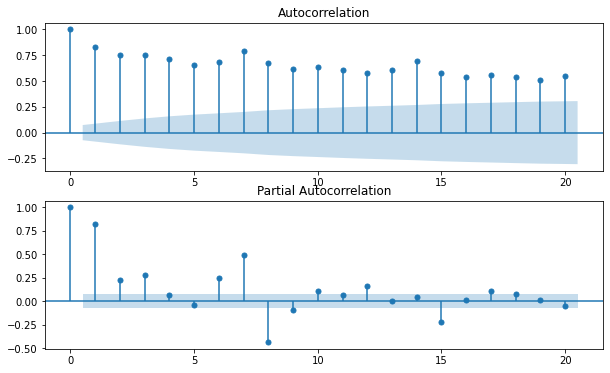

In [86]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(USA_train_imputed['new_cases'], lags=20, ax=ax1)
plot_pacf(USA_train_imputed['new_cases'], lags=20, ax=ax2)
plt.show()
# Correlation Bumps at lags of 7 and 14, so we will add lags for those values (Auto arima will do this by itself).

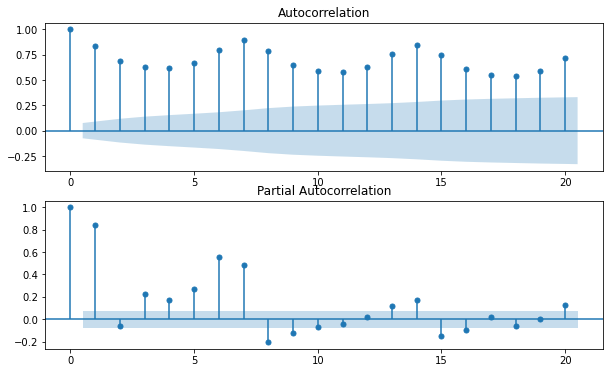

In [331]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(Brazil_train_imputed['new_cases'], lags=20, ax=ax1)
plot_pacf(Brazil_train_imputed['new_cases'], lags=20, ax=ax2)
plt.show()
# Correlation Bumps at lags of 7 and 14, so we will add lags for those values (Auto arima will do this by itself).

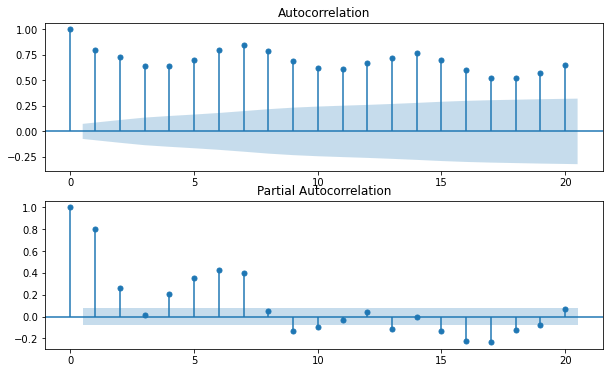

In [332]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(Germany_train_imputed['new_cases'], lags=20, ax=ax1)
plot_pacf(Germany_train_imputed['new_cases'], lags=20, ax=ax2)
plt.show()
# Correlation Bumps at lags of 7 and 14, so we will add lags for those values (Auto arima will do this by itself).

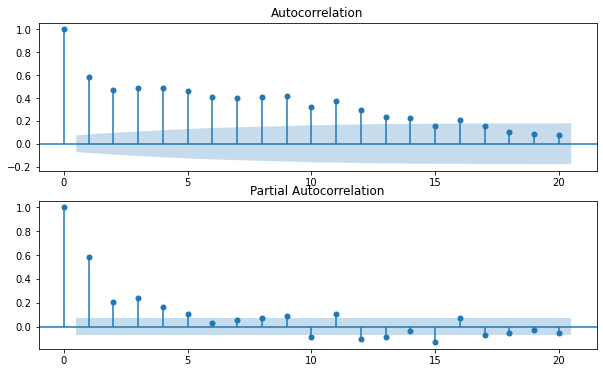

In [333]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(China_train_imputed['new_cases'], lags=20, ax=ax1)
plot_pacf(China_train_imputed['new_cases'], lags=20, ax=ax2)
plt.show()
# Correlation Bumps are where?

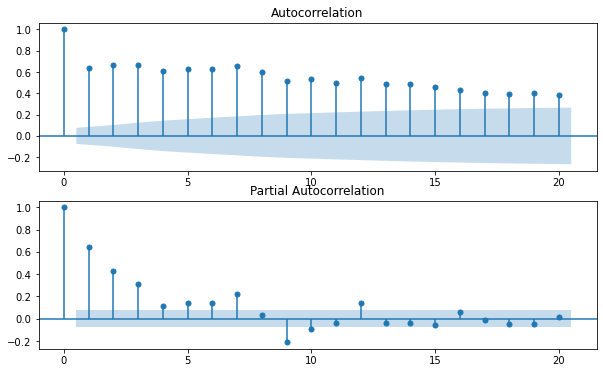

In [334]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(Nigeria_train_imputed['new_cases'], lags=20, ax=ax1)
plot_pacf(Nigeria_train_imputed['new_cases'], lags=20, ax=ax2)
plt.show()
# Correlation Bumps at lags of 7. Anything else? Maybe 12?

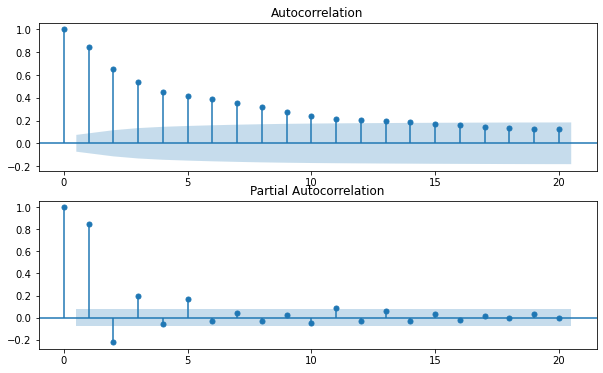

In [335]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(Australia_train_imputed['new_cases'], lags=20, ax=ax1)
plot_pacf(Australia_train_imputed['new_cases'], lags=20, ax=ax2)
plt.show()
# Correlation Bumps at not really existant?

In [87]:
# Adding lags of 7 and 14 to USA train + test
USA_train_imputed['new_cases_Lag_7'] = USA_train_imputed['new_cases'].shift(7)
USA_train_imputed['new_cases_Lag_14'] = USA_train_imputed['new_cases'].shift(14)

USA_test_imputed['new_cases_Lag_7'] = USA_test_imputed['new_cases'].shift(7)
USA_test_imputed['new_cases_Lag_14'] = USA_test_imputed['new_cases'].shift(14)

In [88]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [89]:
# Adding Rolling statistics to USA train (14 day rolling average)
rolling_mean = USA_train_imputed['new_cases'].rolling(window=14).mean()
USA_train_imputed['Rolling_Mean_new_cases'] = rolling_mean
rolling_mean = USA_test_imputed['new_cases'].rolling(window=14).mean()
USA_test_imputed['Rolling_Mean_new_cases'] = rolling_mean

In [90]:
# Add Weekend/Weekday Feature
USA_train_imputed.reset_index(inplace=True)
USA_train_imputed['date'] = pd.to_datetime(USA_train_imputed['date'])
USA_train_imputed['Weekend'] = USA_train_imputed['date'].dt.dayofweek > 4 
USA_train_imputed = USA_train_imputed.set_index('date')

In [91]:
USA_test_imputed.reset_index(inplace=True)
USA_test_imputed['date'] = pd.to_datetime(USA_test_imputed['date'])
USA_test_imputed['Weekend'] = USA_test_imputed['date'].dt.dayofweek > 4 
USA_test_imputed = USA_test_imputed.set_index('date')

In [92]:
# Checking correlation between weekend and response variable, and we can see there is some correlation
pearson_corr = USA_test_imputed['Weekend'].corr(USA_test_imputed['new_cases'], method='pearson')
print(f"Pearson correlation coefficient: {pearson_corr}")

Pearson correlation coefficient: -0.3659847850555484


In [93]:
# Now, Repeat above steps for all other countries
# Adding lags of 7 and 14 to Brazil train + test
Brazil_train_imputed['new_cases_Lag_7'] = Brazil_train_imputed['new_cases'].shift(7)
Brazil_train_imputed['new_cases_Lag_14'] = Brazil_train_imputed['new_cases'].shift(14)

Brazil_test_imputed['new_cases_Lag_7'] = Brazil_test_imputed['new_cases'].shift(7)
Brazil_test_imputed['new_cases_Lag_14'] = Brazil_test_imputed['new_cases'].shift(14)

rolling_mean = Brazil_train_imputed['new_cases'].rolling(window=14).mean()
Brazil_train_imputed['Rolling_Mean_new_cases'] = rolling_mean
rolling_mean = Brazil_test_imputed['new_cases'].rolling(window=14).mean()
Brazil_test_imputed['Rolling_Mean_new_cases'] = rolling_mean

Brazil_train_imputed.reset_index(inplace=True)
Brazil_train_imputed['date'] = pd.to_datetime(Brazil_train_imputed['date'])
Brazil_train_imputed['Weekend'] = Brazil_train_imputed['date'].dt.dayofweek > 4 
Brazil_train_imputed = Brazil_train_imputed.set_index('date')

Brazil_test_imputed.reset_index(inplace=True)
Brazil_test_imputed['date'] = pd.to_datetime(Brazil_test_imputed['date'])
Brazil_test_imputed['Weekend'] = Brazil_test_imputed['date'].dt.dayofweek > 4 
Brazil_test_imputed = Brazil_test_imputed.set_index('date')

# Brazil_train_imputed

In [94]:
# Adding lags of 7 and 14 to Germany train + test
Germany_train_imputed['new_cases_Lag_7'] = Germany_train_imputed['new_cases'].shift(7)
Germany_train_imputed['new_cases_Lag_14'] = Germany_train_imputed['new_cases'].shift(14)

Germany_test_imputed['new_cases_Lag_7'] = Germany_test_imputed['new_cases'].shift(7)
Germany_test_imputed['new_cases_Lag_14'] = Germany_test_imputed['new_cases'].shift(14)

rolling_mean = Germany_train_imputed['new_cases'].rolling(window=14).mean()
Germany_train_imputed['Rolling_Mean_new_cases'] = rolling_mean
rolling_mean = Germany_test_imputed['new_cases'].rolling(window=14).mean()
Germany_test_imputed['Rolling_Mean_new_cases'] = rolling_mean

Germany_train_imputed.reset_index(inplace=True)
Germany_train_imputed['date'] = pd.to_datetime(Germany_train_imputed['date'])
Germany_train_imputed['Weekend'] = Germany_train_imputed['date'].dt.dayofweek > 4 
Germany_train_imputed = Germany_train_imputed.set_index('date')

Germany_test_imputed.reset_index(inplace=True)
Germany_test_imputed['date'] = pd.to_datetime(Germany_test_imputed['date'])
Germany_test_imputed['Weekend'] = Germany_test_imputed['date'].dt.dayofweek > 4 
Germany_test_imputed = Germany_test_imputed.set_index('date')

# Germany_train_imputed

In [95]:
# Adding lags of 7 and 14 to Nigeria train + test
Nigeria_train_imputed['new_cases_Lag_7'] = Nigeria_train_imputed['new_cases'].shift(7)
Nigeria_train_imputed['new_cases_Lag_14'] = Nigeria_train_imputed['new_cases'].shift(14)

Nigeria_test_imputed['new_cases_Lag_7'] = Nigeria_test_imputed['new_cases'].shift(7)
Nigeria_test_imputed['new_cases_Lag_14'] = Nigeria_test_imputed['new_cases'].shift(14)

rolling_mean = Nigeria_train_imputed['new_cases'].rolling(window=14).mean()
Nigeria_train_imputed['Rolling_Mean_new_cases'] = rolling_mean
rolling_mean = Nigeria_test_imputed['new_cases'].rolling(window=14).mean()
Nigeria_test_imputed['Rolling_Mean_new_cases'] = rolling_mean

Nigeria_train_imputed.reset_index(inplace=True)
Nigeria_train_imputed['date'] = pd.to_datetime(Nigeria_train_imputed['date'])
Nigeria_train_imputed['Weekend'] = Nigeria_train_imputed['date'].dt.dayofweek > 4 
Nigeria_train_imputed = Nigeria_train_imputed.set_index('date')

Nigeria_test_imputed.reset_index(inplace=True)
Nigeria_test_imputed['date'] = pd.to_datetime(Nigeria_test_imputed['date'])
Nigeria_test_imputed['Weekend'] = Nigeria_test_imputed['date'].dt.dayofweek > 4 
Nigeria_test_imputed = Nigeria_test_imputed.set_index('date')

# Nigeria_train_imputed

In [96]:
# Adding lags of 7 and 14 to China train + test
China_train_imputed['new_cases_Lag_7'] = China_train_imputed['new_cases'].shift(7)
China_train_imputed['new_cases_Lag_14'] = China_train_imputed['new_cases'].shift(14)

China_test_imputed['new_cases_Lag_7'] = China_test_imputed['new_cases'].shift(7)
China_test_imputed['new_cases_Lag_14'] = China_test_imputed['new_cases'].shift(14)

rolling_mean = China_train_imputed['new_cases'].rolling(window=14).mean()
China_train_imputed['Rolling_Mean_new_cases'] = rolling_mean
rolling_mean = China_test_imputed['new_cases'].rolling(window=14).mean()
China_test_imputed['Rolling_Mean_new_cases'] = rolling_mean

China_train_imputed.reset_index(inplace=True)
China_train_imputed['date'] = pd.to_datetime(China_train_imputed['date'])
China_train_imputed['Weekend'] = China_train_imputed['date'].dt.dayofweek > 4 
China_train_imputed = China_train_imputed.set_index('date')

China_test_imputed.reset_index(inplace=True)
China_test_imputed['date'] = pd.to_datetime(China_test_imputed['date'])
China_test_imputed['Weekend'] = China_test_imputed['date'].dt.dayofweek > 4 
China_test_imputed = China_test_imputed.set_index('date')

# China_train_imputed

In [97]:
# Adding lags of 7 and 14 to Australia train + test
Australia_train_imputed['new_cases_Lag_7'] = Australia_train_imputed['new_cases'].shift(7)
Australia_train_imputed['new_cases_Lag_14'] = Australia_train_imputed['new_cases'].shift(14)

Australia_test_imputed['new_cases_Lag_7'] = Australia_test_imputed['new_cases'].shift(7)
Australia_test_imputed['new_cases_Lag_14'] = Australia_test_imputed['new_cases'].shift(14)

rolling_mean = Australia_train_imputed['new_cases'].rolling(window=14).mean()
Australia_train_imputed['Rolling_Mean_new_cases'] = rolling_mean
rolling_mean = Australia_test_imputed['new_cases'].rolling(window=14).mean()
Australia_test_imputed['Rolling_Mean_new_cases'] = rolling_mean

Australia_train_imputed.reset_index(inplace=True)
Australia_train_imputed['date'] = pd.to_datetime(Australia_train_imputed['date'])
Australia_train_imputed['Weekend'] = Australia_train_imputed['date'].dt.dayofweek > 4 
Australia_train_imputed = Australia_train_imputed.set_index('date')

Australia_test_imputed.reset_index(inplace=True)
Australia_test_imputed['date'] = pd.to_datetime(Australia_test_imputed['date'])
Australia_test_imputed['Weekend'] = Australia_test_imputed['date'].dt.dayofweek > 4 
Australia_test_imputed = Australia_test_imputed.set_index('date')

# Australia_train_imputed

# XGBoost for countries

## USA

In [98]:
# USA_train_imputed.dtypes

In [99]:
m1_USA = xgb.XGBRegressor(learning_rate=0.01, max_depth=4, n_estimators=500, n_jobs=-1, random_state=0)
m1_USA.fit(USA_train_imputed.drop(columns = ['new_cases', 'iso_code', 'location', 'continent'], axis=1), USA_train_imputed['new_cases'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [100]:
train_pred = pd.DataFrame(m1_USA.predict(USA_train_imputed.drop(columns = ['new_cases', 'iso_code', 'location', 'continent'], axis=1)), columns=['yhat'], index=USA_train_imputed.index)
train_pred.head()

,yhat
date,
2020-01-22,234.418915
2020-01-23,234.418915
2020-01-24,234.418915
2020-01-25,234.418915
2020-01-26,234.418915


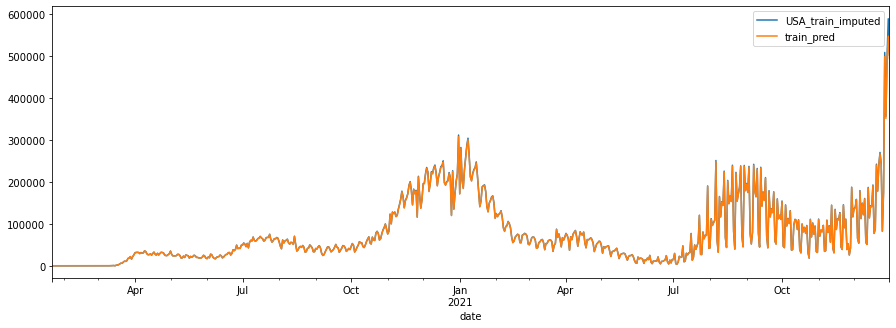

In [101]:
pd.concat([USA_train_imputed['new_cases'],train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['USA_train_imputed', 'train_pred'])

In [102]:
### Above models appears to overfit for USA train imputed dataset... Will need to check in with Rakin and Sid over the weekend

# Prophet Single for all countries

## USA (using imputed dataframe)

In [324]:
train = USA_train_imputed.iloc[:]['new_cases']
test = USA_test_imputed.iloc[:]['new_cases']

In [325]:
USA_model = prophet.Prophet(growth = "linear", daily_seasonality = True, weekly_seasonality = True).fit(train.reset_index().rename(columns={'date':'ds', 'new_cases':'y'}))

18:58:51 - cmdstanpy - INFO - Chain [1] start processing
18:58:51 - cmdstanpy - INFO - Chain [1] done processing


In [326]:
train_pred = USA_model.predict(train.reset_index().rename(columns={'date':'ds', 'new_cases':'y'})).set_index('ds')
train_pred.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,
2020-01-22,-2282.713011,-67055.884810,60313.834603,-2282.713011,-2282.713011,-1856.496993,-1856.496993,-1856.496993,-9163.482944,-9163.482944,-9163.482944,7306.985951,7306.985951,7306.985951,0.0,0.0,0.0,-4139.210004
2020-01-23,-1945.172730,-66441.272729,60165.463945,-1945.172730,-1945.172730,-496.996431,-496.996431,-496.996431,-9163.482944,-9163.482944,-9163.482944,8666.486513,8666.486513,8666.486513,0.0,0.0,0.0,-2442.169161
2020-01-24,-1607.632449,-49062.561574,80022.657939,-1607.632449,-1607.632449,11188.040755,11188.040755,11188.040755,-9163.482944,-9163.482944,-9163.482944,20351.523699,20351.523699,20351.523699,0.0,0.0,0.0,9580.408306
2020-01-25,-1270.092168,-88067.569718,43747.981880,-1270.092168,-1270.092168,-23544.119205,-23544.119205,-23544.119205,-9163.482944,-9163.482944,-9163.482944,-14380.636261,-14380.636261,-14380.636261,0.0,0.0,0.0,-24814.211373
2020-01-26,-932.551887,-99072.474311,31163.664696,-932.551887,-932.551887,-35456.212312,-35456.212312,-35456.212312,-9163.482944,-9163.482944,-9163.482944,-26292.729368,-26292.729368,-26292.729368,0.0,0.0,0.0,-36388.764199


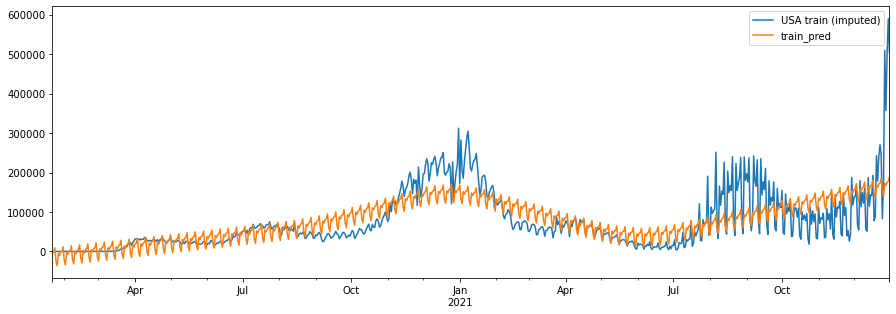

In [327]:
pd.concat([train,train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['USA train (imputed)', 'train_pred'])

In [328]:
se = np.square(train_pred.loc[:, 'yhat'] - train)
mse = np.mean(se)
train_rmse = np.sqrt(mse)
train_rmse

50297.449913472425

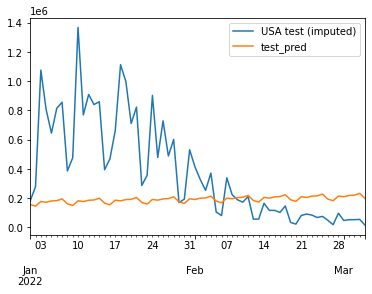

In [329]:
test_pred = USA_model.predict(test.reset_index().rename(columns={'date':'ds', 'new_cases':'y'})).set_index('ds')
pd.concat([test,test_pred['yhat']], axis=1).plot()
plt.legend(['USA test (imputed)', 'test_pred'])

In [330]:
se = np.square(test_pred.loc[:, 'yhat'] - test)
mse = np.mean(se)
test_rmse = np.sqrt(mse)
test_rmse

394577.93913951045

## Brazil (using imputed dataframe)

In [290]:
train = Brazil_train_imputed.iloc[:]['new_cases']
test = Brazil_test_imputed.iloc[:]['new_cases']

In [297]:
Brazil_model = prophet.Prophet().fit(train.reset_index().rename(columns={'date':'ds', 'new_cases':'y'}))

18:04:31 - cmdstanpy - INFO - Chain [1] start processing
18:04:31 - cmdstanpy - INFO - Chain [1] done processing


In [298]:
train_pred = Brazil_model.predict(train.reset_index().rename(columns={'date':'ds', 'new_cases':'y'})).set_index('ds')
train_pred.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,
2020-02-26,-3948.775387,-10790.150705,18869.462011,-3948.775387,-3948.775387,7600.521298,7600.521298,7600.521298,7600.521298,7600.521298,7600.521298,0.0,0.0,0.0,3651.745911
2020-02-27,-3684.455280,-10665.892108,17788.095964,-3684.455280,-3684.455280,7554.924490,7554.924490,7554.924490,7554.924490,7554.924490,7554.924490,0.0,0.0,0.0,3870.469210
2020-02-28,-3420.135173,-10655.705014,16765.316984,-3420.135173,-3420.135173,5824.221026,5824.221026,5824.221026,5824.221026,5824.221026,5824.221026,0.0,0.0,0.0,2404.085853
2020-02-29,-3155.815065,-17579.496091,11051.595106,-3155.815065,-3155.815065,23.903473,23.903473,23.903473,23.903473,23.903473,23.903473,0.0,0.0,0.0,-3131.911592
2020-03-01,-2891.494958,-30267.706837,-2108.366944,-2891.494958,-2891.494958,-13747.946941,-13747.946941,-13747.946941,-13747.946941,-13747.946941,-13747.946941,0.0,0.0,0.0,-16639.441899


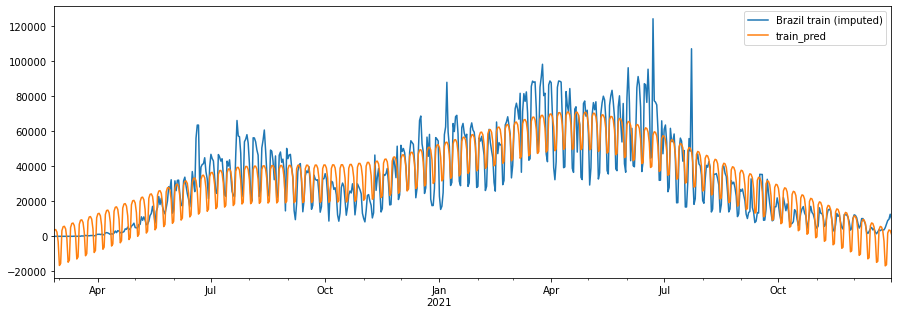

In [299]:
pd.concat([train,train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['Brazil train (imputed)', 'train_pred'])

In [300]:
se = np.square(train_pred.loc[:, 'yhat'] - train)
mse = np.mean(se)
train_rmse = np.sqrt(mse)
train_rmse

11274.77583294517

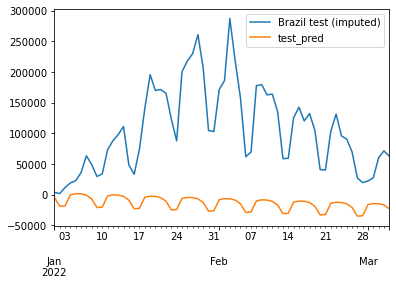

In [301]:
test_pred = Brazil_model.predict(test.reset_index().rename(columns={'date':'ds', 'new_cases':'y'})).set_index('ds')
pd.concat([test,test_pred['yhat']], axis=1).plot()
plt.legend(['Brazil test (imputed)', 'test_pred'])

In [302]:
se = np.square(test_pred.loc[:, 'yhat'] - test)
mse = np.mean(se)
test_rmse = np.sqrt(mse)
test_rmse

135865.05352195224

## Germany

In [283]:
train = Germany_train_imputed.iloc[:]['new_cases']
test = Germany_test_imputed.iloc[:]['new_cases']

In [284]:
Germany_model = prophet.Prophet(growth = "linear", daily_seasonality = True).fit(train.reset_index().rename(columns={'date':'ds', 'new_cases':'y'}))

18:03:02 - cmdstanpy - INFO - Chain [1] start processing
18:03:02 - cmdstanpy - INFO - Chain [1] done processing


In [285]:
train_pred = Germany_model.predict(train.reset_index().rename(columns={'date':'ds', 'new_cases':'y'})).set_index('ds')
train_pred.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,
2020-01-27,-115.157641,-15046.845716,6592.720649,-115.157641,-115.157641,-3913.201138,-3913.201138,-3913.201138,-465.909207,-465.909207,-465.909207,-3447.291931,-3447.291931,-3447.291931,0.0,0.0,0.0,-4028.358779
2020-01-28,-97.451715,-9367.885882,12254.885302,-97.451715,-97.451715,1848.524301,1848.524301,1848.524301,-465.909207,-465.909207,-465.909207,2314.433508,2314.433508,2314.433508,0.0,0.0,0.0,1751.072586
2020-01-29,-79.745789,-8939.107995,14722.349305,-79.745789,-79.745789,3329.190929,3329.190929,3329.190929,-465.909207,-465.909207,-465.909207,3795.100135,3795.100135,3795.100135,0.0,0.0,0.0,3249.445140
2020-01-30,-62.039863,-8627.602840,12724.548207,-62.039863,-62.039863,2752.667745,2752.667745,2752.667745,-465.909207,-465.909207,-465.909207,3218.576951,3218.576951,3218.576951,0.0,0.0,0.0,2690.627882
2020-01-31,-44.333937,-11648.790806,10305.381104,-44.333937,-44.333937,-247.900685,-247.900685,-247.900685,-465.909207,-465.909207,-465.909207,218.008522,218.008522,218.008522,0.0,0.0,0.0,-292.234622


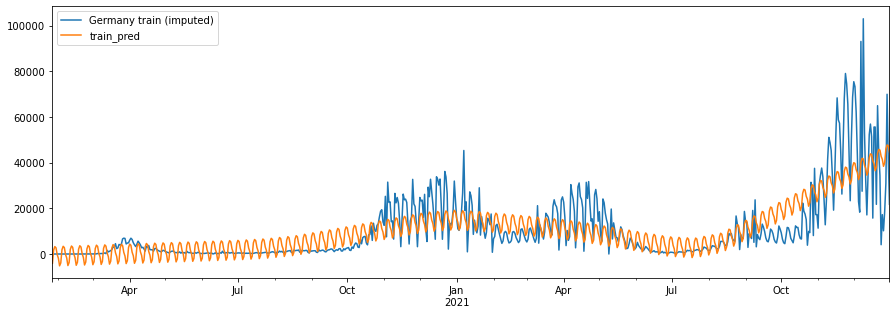

In [287]:
pd.concat([train,train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['Germany train (imputed)', 'train_pred'])

In [286]:
se = np.square(train_pred.loc[:, 'yhat'] - train)
mse = np.mean(se)
train_rmse = np.sqrt(mse)
train_rmse

8786.505379395387

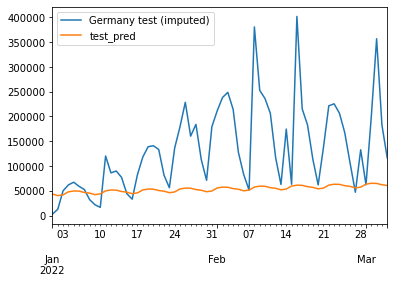

In [288]:
test_pred = Germany_model.predict(test.reset_index().rename(columns={'date':'ds', 'new_cases':'y'})).set_index('ds')
pd.concat([test,test_pred['yhat']], axis=1).plot()
plt.legend(['Germany test (imputed)', 'test_pred'])

In [289]:
se = np.square(test_pred.loc[:, 'yhat'] - test)
mse = np.mean(se)
test_rmse = np.sqrt(mse)
test_rmse

116113.82334449083

## China

In [276]:
train = China_train_imputed.iloc[:]['new_cases']
test = China_test_imputed.iloc[:]['new_cases']

In [277]:
China_model = prophet.Prophet().fit(train.reset_index().rename(columns={'date':'ds', 'new_cases':'y'}))

18:00:26 - cmdstanpy - INFO - Chain [1] start processing
18:00:27 - cmdstanpy - INFO - Chain [1] done processing


In [278]:
train_pred = China_model.predict(train.reset_index().rename(columns={'date':'ds', 'new_cases':'y'})).set_index('ds')
train_pred.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,
2020-01-22,2020.648958,1126.894238,2792.019810,2020.648958,2020.648958,-66.939393,-66.939393,-66.939393,-66.939393,-66.939393,-66.939393,0.0,0.0,0.0,1953.709565
2020-01-23,1996.304038,1279.076545,2908.135619,1996.304038,1996.304038,93.042829,93.042829,93.042829,93.042829,93.042829,93.042829,0.0,0.0,0.0,2089.346867
2020-01-24,1971.959117,1181.229039,2793.735298,1971.959117,1971.959117,13.065560,13.065560,13.065560,13.065560,13.065560,13.065560,0.0,0.0,0.0,1985.024678
2020-01-25,1947.614197,1084.611958,2794.047029,1947.614197,1947.614197,-24.722343,-24.722343,-24.722343,-24.722343,-24.722343,-24.722343,0.0,0.0,0.0,1922.891854
2020-01-26,1923.269277,1117.664064,2785.075793,1923.269277,1923.269277,2.133674,2.133674,2.133674,2.133674,2.133674,2.133674,0.0,0.0,0.0,1925.402951


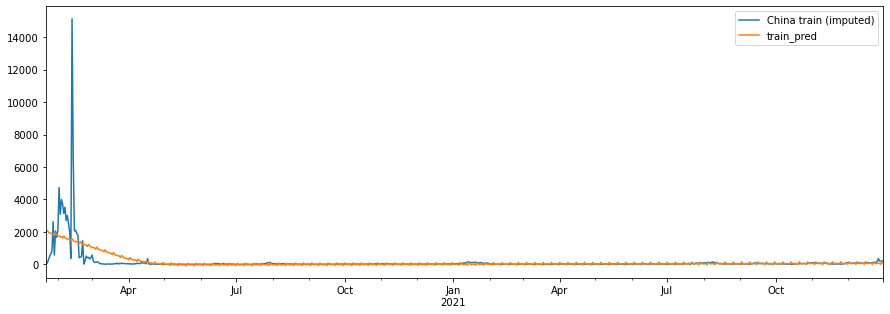

In [279]:
pd.concat([train,train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['China train (imputed)', 'train_pred'])

In [280]:
se = np.square(train_pred.loc[:, 'yhat'] - train)
mse = np.mean(se)
train_rmse = np.sqrt(mse)
train_rmse

631.6916947126774

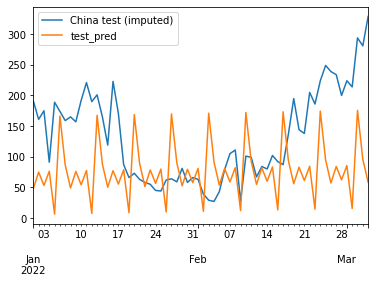

In [281]:
test_pred = China_model.predict(test.reset_index().rename(columns={'date':'ds', 'new_cases':'y'})).set_index('ds')
pd.concat([test,test_pred['yhat']], axis=1).plot()
plt.legend(['China test (imputed)', 'test_pred'])

In [282]:
se = np.square(test_pred.loc[:, 'yhat'] - test)
mse = np.mean(se)
test_rmse = np.sqrt(mse)
test_rmse

101.30750757521926

## Nigeria

In [263]:
train = Nigeria_train_imputed.iloc[:]['new_cases']
test = Nigeria_test_imputed.iloc[:]['new_cases']

In [264]:
Nigeria_model = prophet.Prophet(growth = "linear", daily_seasonality = True).fit(train.reset_index().rename(columns={'date':'ds', 'new_cases':'y'}))

17:59:26 - cmdstanpy - INFO - Chain [1] start processing
17:59:26 - cmdstanpy - INFO - Chain [1] done processing


In [265]:
train_pred = Nigeria_model.predict(train.reset_index().rename(columns={'date':'ds', 'new_cases':'y'})).set_index('ds')
train_pred.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,
2020-02-28,-0.678168,-474.152443,483.846177,-0.678168,-0.678168,20.191531,20.191531,20.191531,-6.53147,-6.53147,-6.53147,26.723002,26.723002,26.723002,0.0,0.0,0.0,19.513363
2020-02-29,2.623574,-476.343438,444.788981,2.623574,2.623574,-8.698840,-8.698840,-8.698840,-6.53147,-6.53147,-6.53147,-2.167370,-2.167370,-2.167370,0.0,0.0,0.0,-6.075267
2020-03-01,5.925315,-561.546529,388.404411,5.925315,5.925315,-83.435613,-83.435613,-83.435613,-6.53147,-6.53147,-6.53147,-76.904143,-76.904143,-76.904143,0.0,0.0,0.0,-77.510298
2020-03-02,9.227057,-511.975470,427.252424,9.227057,9.227057,-57.152608,-57.152608,-57.152608,-6.53147,-6.53147,-6.53147,-50.621138,-50.621138,-50.621138,0.0,0.0,0.0,-47.925551
2020-03-03,12.528799,-540.771746,471.409799,12.528799,12.528799,-25.597786,-25.597786,-25.597786,-6.53147,-6.53147,-6.53147,-19.066315,-19.066315,-19.066315,0.0,0.0,0.0,-13.068987


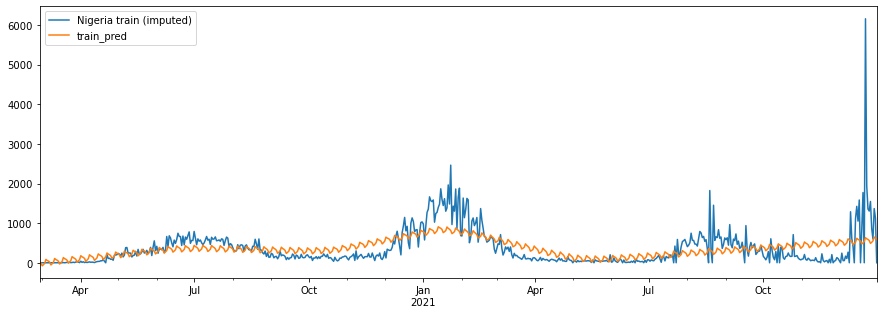

In [266]:
pd.concat([train,train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['Nigeria train (imputed)', 'train_pred'])

In [267]:
se = np.square(train_pred.loc[:, 'yhat'] - train)
mse = np.mean(se)
train_rmse = np.sqrt(mse)
train_rmse

371.4604358432025

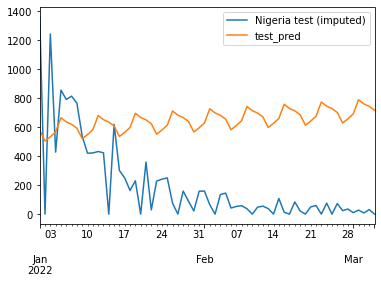

In [268]:
test_pred = Nigeria_model.predict(test.reset_index().rename(columns={'date':'ds', 'new_cases':'y'})).set_index('ds')
pd.concat([test,test_pred['yhat']], axis=1).plot()
plt.legend(['Nigeria test (imputed)', 'test_pred'])

In [269]:
se = np.square(test_pred.loc[:, 'yhat'] - test)
mse = np.mean(se)
test_rmse = np.sqrt(mse)
test_rmse

554.2272998841272

## Australia

In [317]:
train = Australia_train_imputed.iloc[:]['new_cases']
test = Australia_test_imputed.iloc[:]['new_cases']
print(train.shape, test.shape)

(706,) (64,)


In [318]:
Australia_model = prophet.Prophet(growth = "linear", daily_seasonality = True).fit(train.reset_index().rename(columns={'date':'ds', 'new_cases':'y'}))

18:49:57 - cmdstanpy - INFO - Chain [1] start processing
18:49:57 - cmdstanpy - INFO - Chain [1] done processing


In [319]:
train_pred = Australia_model.predict(train.reset_index().rename(columns={'date':'ds', 'new_cases':'y'})).set_index('ds')
train_pred.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,
2020-01-26,26.664910,-2195.086734,2246.463217,26.664910,26.664910,-50.646770,-50.646770,-50.646770,89.121468,89.121468,89.121468,-139.768238,-139.768238,-139.768238,0.0,0.0,0.0,-23.981860
2020-01-27,26.399370,-2368.238615,2279.878700,26.399370,26.399370,-36.756530,-36.756530,-36.756530,89.121468,89.121468,89.121468,-125.877998,-125.877998,-125.877998,0.0,0.0,0.0,-10.357159
2020-01-28,26.133831,-2132.997657,2222.997649,26.133831,26.133831,56.412561,56.412561,56.412561,89.121468,89.121468,89.121468,-32.708907,-32.708907,-32.708907,0.0,0.0,0.0,82.546391
2020-01-29,25.868291,-2168.371327,2483.945273,25.868291,25.868291,161.680866,161.680866,161.680866,89.121468,89.121468,89.121468,72.559398,72.559398,72.559398,0.0,0.0,0.0,187.549157
2020-01-30,25.602751,-2022.132728,2575.225633,25.602751,25.602751,277.403161,277.403161,277.403161,89.121468,89.121468,89.121468,188.281693,188.281693,188.281693,0.0,0.0,0.0,303.005912


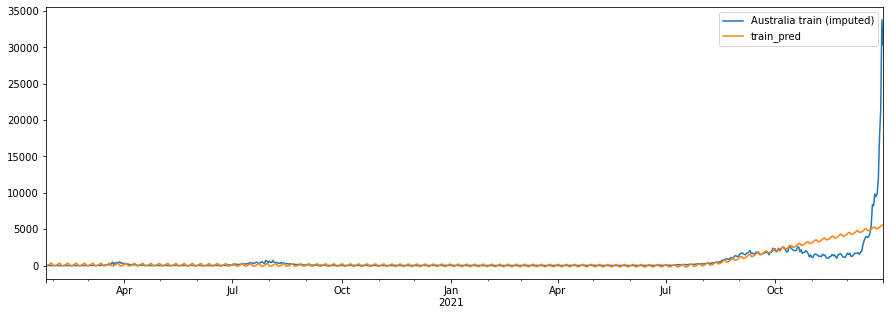

In [320]:
pd.concat([train,train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['Australia train (imputed)', 'train_pred'])

In [321]:
se = np.square(train_pred.loc[:, 'yhat'] - train)
mse = np.mean(se)
train_rmse = np.sqrt(mse)
train_rmse

1801.1958630648892

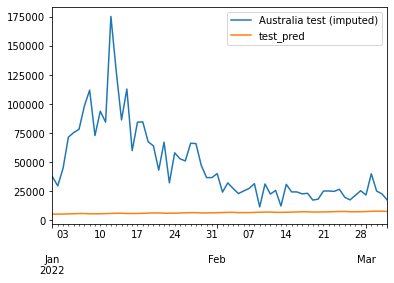

In [322]:
test_pred = Australia_model.predict(test.reset_index().rename(columns={'date':'ds', 'new_cases':'y'})).set_index('ds')
pd.concat([test,test_pred['yhat']], axis=1).plot()
plt.legend(['Australia test (imputed)', 'test_pred'])

In [323]:
se = np.square(test_pred.loc[:, 'yhat'] - test)
mse = np.mean(se)
test_rmse = np.sqrt(mse)
test_rmse

52177.383785882696